### GRU RNN Implementation

In this notebook we will implement a GRU RNN in order to forecast the AQI with all of the available meteorological data at the Chicago SH Bell monitoring site.

In [1]:
import os
from collections import deque
import random
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, LSTM, BatchNormalization, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator
from google.cloud import storage

Using TensorFlow backend.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


#### Making Train/Test Splits

In [4]:
aqi_df = pd.read_csv('./data/SH_Bell/combined_meteor_and_sample.csv', index_col='Unnamed: 0', parse_dates=True)
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,AWD_cos,AWD_sin,Sample Value
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,0.998027,-0.062791,4.0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,0.978148,-0.207912,6.0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,0.999925,-0.012217,7.0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,0.991671,-0.128796,6.0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,0.841511,-0.540240,8.0


In [18]:
target_names = ['Sample Value']
shift_days = 1
shift_steps = shift_days*4 # Number of hours
seq_length = 24*8*1
aqi_df_targets = aqi_df[target_names].shift(-shift_steps)
aqi_df['target'] = aqi_df_targets['Sample Value']

In [19]:
aqi_df.head()

,AWS Mph WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,AWD_cos,AWD_sin,Sample Value,target
2017-04-01 00:00:00,5.989,15.55,38.74,29.41,0.998027,-0.062791,4.0,8.0
2017-04-01 01:00:00,5.059,11.30,39.46,29.44,0.978148,-0.207912,6.0,11.0
2017-04-01 02:00:00,5.390,11.30,39.08,29.45,0.999925,-0.012217,7.0,16.0
2017-04-01 03:00:00,5.233,11.59,38.95,29.47,0.991671,-0.128796,6.0,20.0
2017-04-01 04:00:00,3.614,8.68,38.86,29.49,0.841511,-0.540240,8.0,16.0


In [20]:
test_split = 0.2
times = sorted(aqi_df.index.values)
test_times = times[-int(test_split * len(aqi_df))]
aqi_val_df = aqi_df[(aqi_df.index >= test_times)].dropna()
aqi_train_df = aqi_df[(aqi_df.index < test_times)]

In [21]:
def preprocess_df(train_df, val_df):
    
    combined = [train_df, val_df]
    
    for col in train_df.columns:
        if 'AWD' not in col:
            mm = MinMaxScaler()
            train_df.loc[:,col] = mm.fit_transform(train_df.loc[:,col].values.reshape(-1,1))
            val_df.loc[:,col] = mm.transform(val_df.loc[:,col].values.reshape(-1,1))
     
    train_X, train_y, val_X, val_y = [], [], [], []
    
    for i, df in enumerate(combined):
        sequential_data = []
        prev_hours = deque(maxlen=seq_length)
        for j in df.values:
            prev_hours.append([n for n in j[:-1]])
            if len(prev_hours) == seq_length:
                sequential_data.append([np.array(prev_hours), j[-1]])
        
        random.shuffle(sequential_data)
        
        if i == 0:
            for seq, target in sequential_data:
                train_X.append(seq)
                train_y.append(target)
        else:
            for seq, target in sequential_data:
                val_X.append(seq)
                val_y.append(target)
                
    return np.array(train_X), train_y, np.array(val_X), val_y
        

In [22]:
train_X, train_y, val_X, val_y = preprocess_df(aqi_train_df, aqi_val_df)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [23]:
epochs = 10
batch_size = 64
name = '%d-SEQ-%d-PRED-%d' % (seq_length, shift_steps, int(time.time()))

In [30]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1:]), return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# model.add(LSTM(128, input_shape=(train_X.shape[1:]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(LSTM(128, input_shape=(train_X.shape[1:])))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])

history = model.fit(train_X, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_X, val_y))

Train on 18510 samples, validate on 4480 samples
Epoch 1/10
18510/18510 [==============================] - 37s 2ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/10
18510/18510 [==============================] - 37s 2ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/10
 8256/18510 [============>.................] - ETA: 19s - loss: 0.0030 - mse: 0.0030

KeyboardInterrupt: 

In [ ]:
result = model.evaluate(x=np.expand_dims(X_test, axis=0),
                        y=np.expand_dims(y_test, axis=0))

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train
        y_true = y_train
    else:
        # Use test-data.
        x = X_test
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_scaler.inverse_transform(y_true[start_idx:end_idx])
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

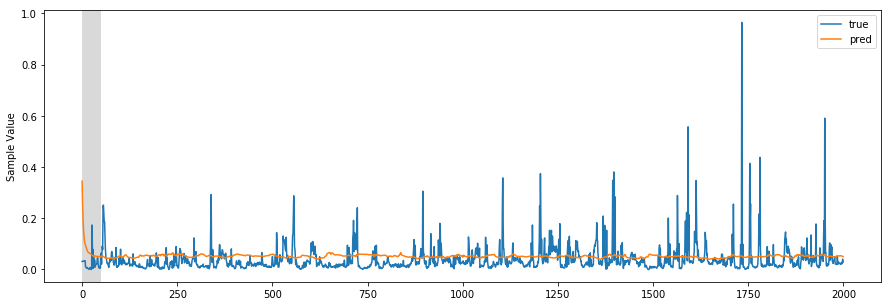

In [372]:
plot_comparison(start_idx=0, length=2000, train=False)

In [202]:
model.save('./chicago_gru_4h.hf5')